# Libraries

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.12.0'

In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

In [5]:
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1492 entries, 1 to 1492
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   INPUT0    1492 non-null   float64
 1   INPUT1    1492 non-null   float64
 2   INPUT2    1492 non-null   float64
 3   INPUT3    1492 non-null   float64
 4   INPUT4    1492 non-null   float64
 5   INPUT5    1492 non-null   float64
 6   INPUT6    1492 non-null   float64
 7   INPUT7    1492 non-null   float64
 8   INPUT8    1492 non-null   float64
 9   TARGET_X  1492 non-null   float64
 10  TARGET_Y  1492 non-null   float64
dtypes: float64(11)
memory usage: 139.9 KB


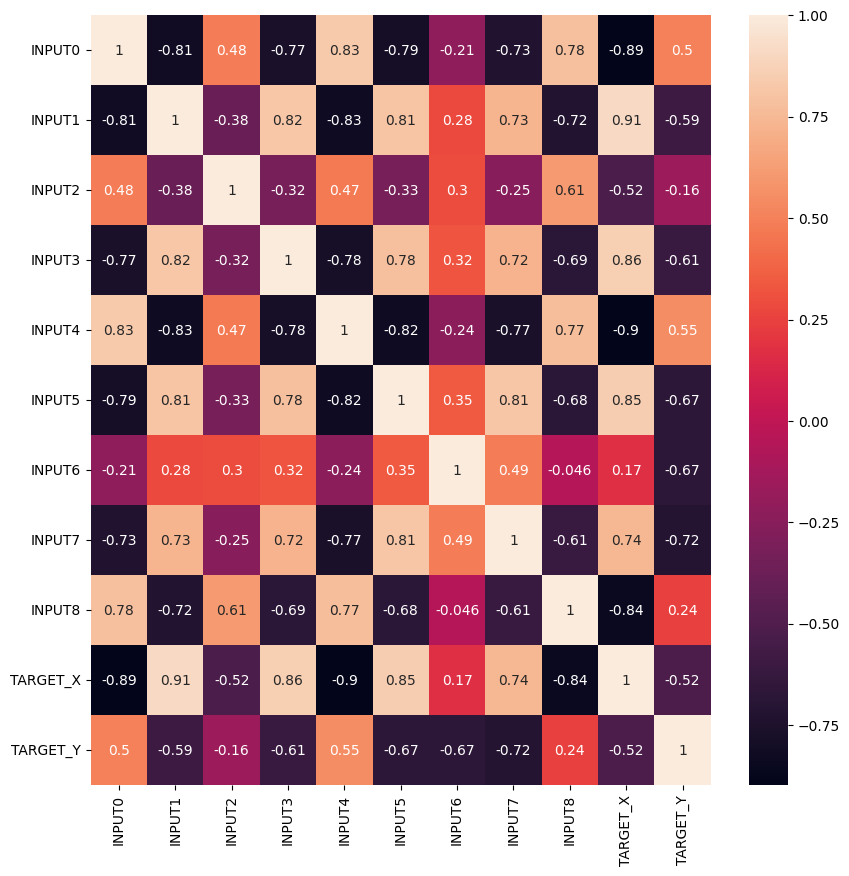

x_train  (1044, 9)
y_train  (1044, 2)
x_test  (448, 9)
y_test  (448, 2)


In [7]:
from set_extraction import x_train, y_train, x_test, y_test

# Models

In [8]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [9]:
results = []

# Neural Networks

## MLP

### Grid search for parameter setting 


In [14]:
from tensorflow import keras
from scikeras.wrappers import KerasRegressor

In [15]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1
from time import time
from tensorflow.math import reduce_mean, sqrt, reduce_sum, square

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
def MEE(actual, predict):
    return reduce_mean(sqrt(reduce_sum(square(actual - predict), axis=-1)))

In [19]:
in_dim = x_train.shape[1]
out_dim = y_train.shape[1]

params = {
    'batch_size': [16], 
    'model__dropout_rate': [0, 0.1], #0.3
    'model__num_hidden_layers': [0, 1],
    'model__h_units': [50, 40, 30],  #60
    'model__learning_rate': [0.008, 0.01, 0.02], 
    'model__momentum': [0.0, 0.01, 0.03, 0.1, 0.5],
    'model__weight_decay': [0.0001, 0.001, 0.01, 0.1],
    'model__activation': ['tanh', 'relu']
}

In [20]:
# define a function to create model
def create_mlp_model(dropout_rate, activation, num_hidden_layers, h_units, learning_rate, momentum, weight_decay): 
    # create model
    model = Sequential()

    model.add(Input(in_dim))
    # add a dropout layer if rate is not null
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))     

    # # Add the hidden layers.
    for i in range(1, num_hidden_layers+1):
        model.add(Dense(h_units, activation=activation))
        if dropout_rate != 0:
            model.add(Dropout(rate=dropout_rate))

    model.add(Dense(out_dim, activation='linear')) 

    # Compile model
    model.compile( 
        optimizer= SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=weight_decay), 
        loss='mean_squared_error',
        metrics=[MEE]
        )    
    
    return model

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
                              patience=20,                              
                              monitor="val_loss",
                              mode='min',
                              restore_best_weights=True,
                              min_delta=0.01,
                              verbose=1
                              )

In [22]:
#hyperparameter tuning with grid search CV
n_jobs_search = -1

start=time()

mlp = KerasRegressor(
                    model=create_mlp_model, 
                    epochs=100, 
                    callbacks=[early_stopping], 
                    random_state=42,
                    validation_split=0.2
                    )

mlp_cv = GridSearchCV(estimator=mlp, param_grid=params, 
                      scoring=make_scorer(lambda x, y : MEE(x, y).numpy(), greater_is_better = False), cv=5, 
                      verbose=4, n_jobs=n_jobs_search, error_score='raise') 

mlp_cv.fit(x_train, y_train) 

print('time for grid search = {:.0f} sec'.format(time()-start))

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Epoch 1/100
53/53 [==============================] - 1s 4ms/step - loss: 56.8495 - MEE: 6.1080 - val_loss: 2.6800 - val_MEE: 1.9118
Epoch 2/100
53/53 [==============================] - 0s 2ms/step - loss: 2.6272 - MEE: 1.9041 - val_loss: 2.4072 - val_MEE: 1.7977
Epoch 3/100
53/53 [==============================] - 0s 2ms/step - loss: 2.3171 - MEE: 1.7605 - val_loss: 2.1223 - val_MEE: 1.6574
Epoch 4/100
53/53 [==============================] - 0s 2ms/step - loss: 2.2338 - MEE: 1.7445 - val_loss: 2.1344 - val_MEE: 1.7243
Epoch 5/100
53/53 [==============================] - 0s 2ms/step - loss: 2.1634 - MEE: 1.6955 - val_loss: 2.0403 - val_MEE: 1.6330
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 2.0756 - MEE: 1.6546 - val_loss: 1.9288 - val_MEE: 1.5638
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 2.0640 - MEE: 1.6611 - val_loss: 2.1080 - val_MEE: 1.6452
Epoch 8/100
53/53

In [23]:
mlp_cv.best_params_

{'batch_size': 16,
 'model__activation': 'tanh',
 'model__dropout_rate': 0,
 'model__h_units': 40,
 'model__learning_rate': 0.01,
 'model__momentum': 0.5,
 'model__num_hidden_layers': 1,
 'model__weight_decay': 0.0001}

In [24]:
# validation
mlp_cv.best_score_

-1.5033600570628964

In [25]:
mlp_cv.best_estimator_

KerasRegressor(
	model=<function create_mlp_model at 0x00000281FFB763E0>
	build_fn=None
	warm_start=False
	random_state=42
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x00000281802B6490>]
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
	model__activation=tanh
	model__dropout_rate=0
	model__h_units=40
	model__learning_rate=0.01
	model__momentum=0.5
	model__num_hidden_layers=1
	model__weight_decay=0.0001
)

In [26]:
best_ep_est = len(mlp_cv.best_estimator_.model_.history.history["MEE"])-20

In [27]:
best_ep_est

80

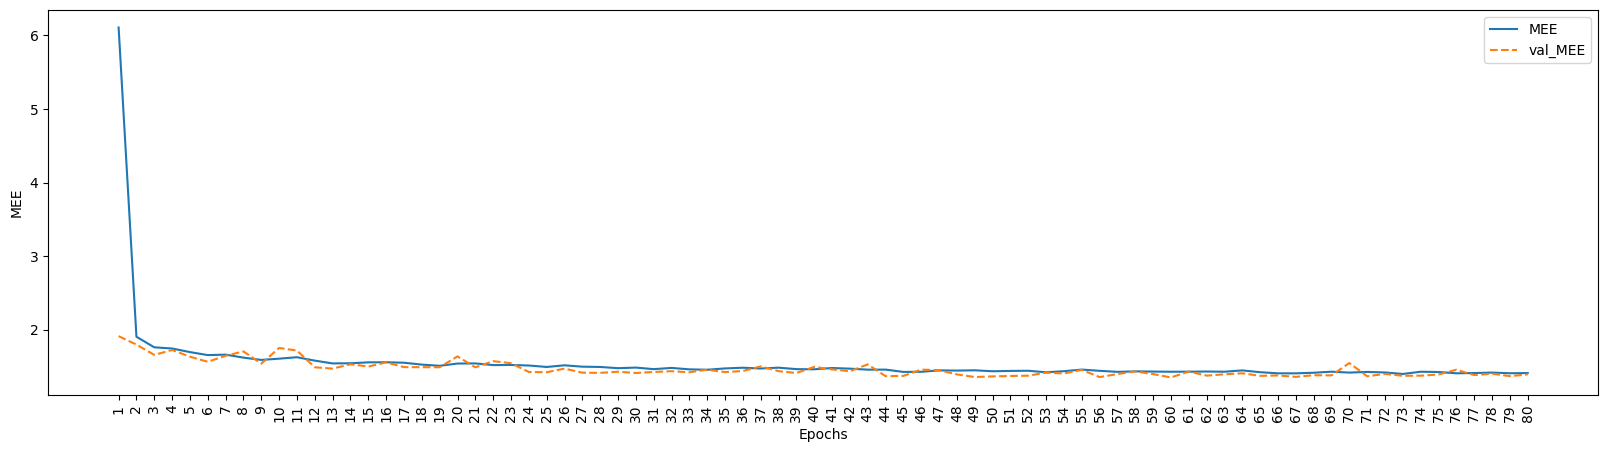

In [28]:
#MEE plot
plt.figure(figsize = (20,5))
plt.plot(mlp_cv.best_estimator_.model_.history.history["MEE"][0:best_ep_est], label='MEE') 
plt.plot(mlp_cv.best_estimator_.model_.history.history["val_MEE"][0:best_ep_est], label='val_MEE', linestyle='dashed')       
plt.xlabel('Epochs')
plt.ylabel('MEE')
#plt.ylim([0,5])
plt.xticks(np.arange(len(mlp_cv.best_estimator_.model_.history.history["MEE"][0:best_ep_est])), 
           np.arange(1, len(mlp_cv.best_estimator_.model_.history.history["MEE"][0:best_ep_est])+1), 
           rotation=90)
plt.legend(loc = 'upper right')

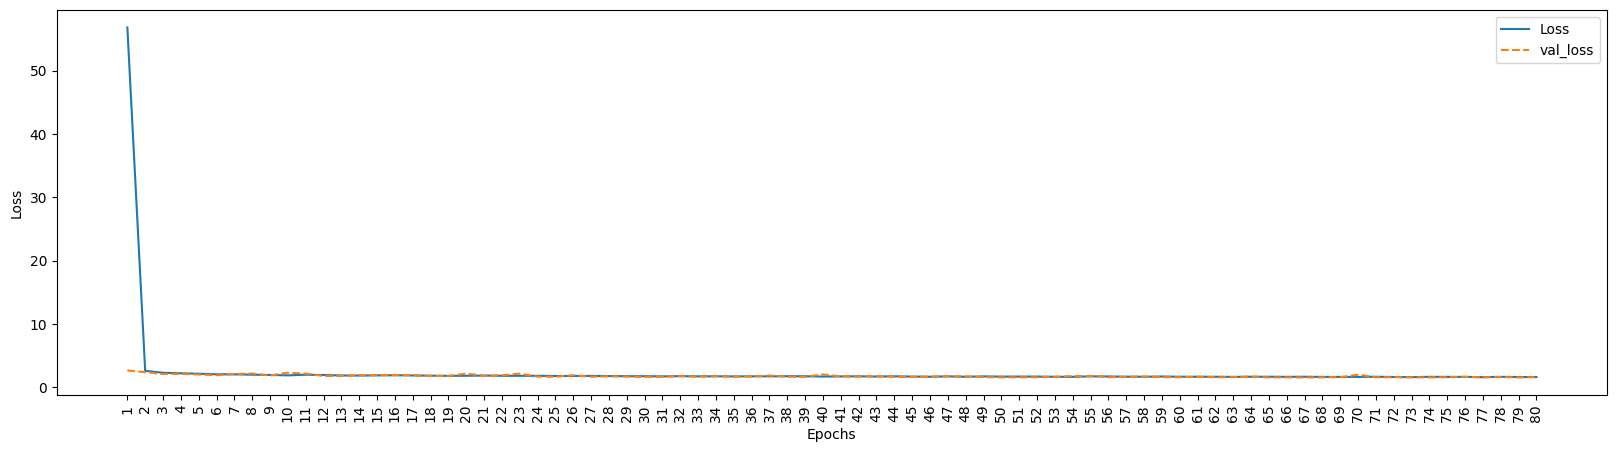

In [29]:
#Loss plot
plt.figure(figsize = (20,5))
plt.plot(mlp_cv.best_estimator_.model_.history.history["loss"][0:best_ep_est], label='Loss') 
plt.plot(mlp_cv.best_estimator_.model_.history.history["val_loss"][0:best_ep_est], label='val_loss', linestyle='dashed')       
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,5])
plt.xticks(np.arange(len(mlp_cv.best_estimator_.model_.history.history["loss"][0:best_ep_est])), 
           np.arange(1, len(mlp_cv.best_estimator_.model_.history.history["loss"][0:best_ep_est])+1), 
           rotation=90)
plt.legend(loc = 'upper right')

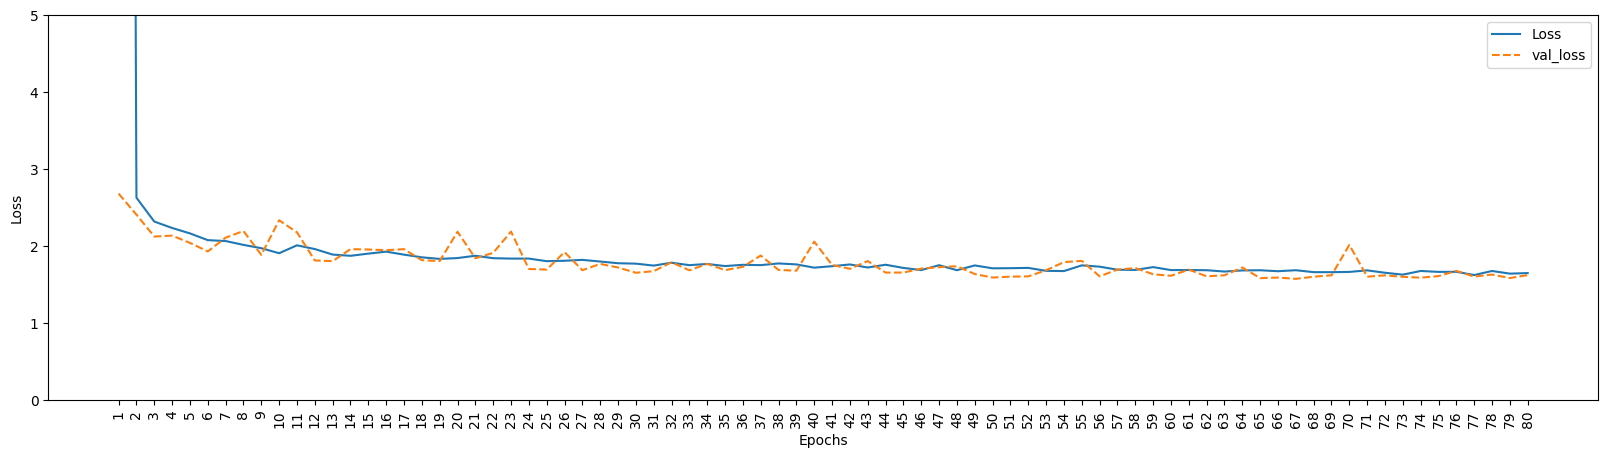

In [30]:
#Loss plot zoom
plt.figure(figsize = (20,5))
plt.plot(mlp_cv.best_estimator_.model_.history.history["loss"][0:best_ep_est], label='Loss') 
plt.plot(mlp_cv.best_estimator_.model_.history.history["val_loss"][0:best_ep_est], label='val_loss', linestyle='dashed')       
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,5])
plt.xticks(np.arange(len(mlp_cv.best_estimator_.model_.history.history["loss"][0:best_ep_est])), 
           np.arange(1, len(mlp_cv.best_estimator_.model_.history.history["loss"][0:best_ep_est])+1), 
           rotation=90)
plt.legend(loc = 'upper right')

Epoch 1/100
5/5 [==============================] - 0s 27ms/step - loss: 418.0999 - MEE: 28.0370 - val_loss: 286.4633 - val_MEE: 23.9238
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 171.2614 - MEE: 16.0819 - val_loss: 16.0080 - val_MEE: 6.0910
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 11.0391 - MEE: 3.5109 - val_loss: 5.6562 - val_MEE: 3.2747
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 4.9775 - MEE: 2.8519 - val_loss: 4.0610 - val_MEE: 2.1284
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 3.6169 - MEE: 2.2209 - val_loss: 3.4648 - val_MEE: 1.8715
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 3.2009 - MEE: 2.0754 - val_loss: 2.7306 - val_MEE: 1.8712
Epoch 7/100
5/5 [==============================] - 0s 6ms/step - loss: 2.9788 - MEE: 2.1118 - val_loss: 3.7953 - val_MEE: 2.0826
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 2.7622 - MEE: 

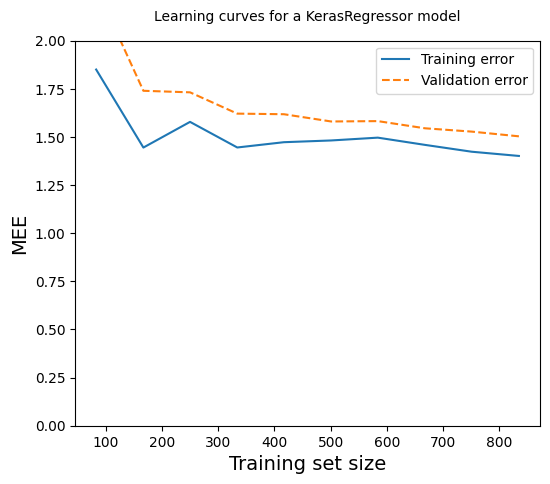

In [31]:
from sklearn.model_selection import learning_curve

### Bundling our previous work into a function ###
def learning_curves(estimator, x, y, train_sizes, cv):

    scoring = make_scorer(lambda x, y : MEE(x, y).numpy(), greater_is_better = False)

    train_sizes, train_scores, validation_scores = learning_curve(estimator, x, y, train_sizes=train_sizes,
                                                                cv = cv, scoring = scoring)
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error', linestyle='dashed')

    plt.ylabel('MEE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 10, y = 1.03)
    plt.legend()
    plt.ylim(0,2)

### Plotting the learning curves ###
plt.figure(figsize = (6,5))

learning_curves(mlp_cv.best_estimator_, x_train, y_train, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 5)

In [32]:
mlp_cv.best_estimator_.model_.save("cup_models/keras.h5")

In [33]:
# Final retraining -------------------------------------------------------------------------

In [34]:
from tensorflow.random import set_seed
set_seed(42)

In [35]:
final_models = []
models_train_mse = []
models_val_mse = []
models_train_mee = []
models_val_mee = []

for i in range(1,6):

    model = KerasRegressor(
                        model=create_mlp_model, 
                        epochs=100, 
                        callbacks=[early_stopping], 
                        validation_split=0.2,
                        verbose=0,
                        **mlp_cv.best_params_
                        )
    
    hist = model.fit(x_train, y_train) 

    models_train_mse.append(hist.history_['loss'])
    models_val_mse.append(hist.history_['val_loss'])
    models_train_mee.append(hist.history_['MEE'])
    models_val_mee.append(hist.history_['val_MEE'])

    final_models.append(model)

    print("Trial", i)

Trial 1
Trial 2
Trial 3
Restoring model weights from the end of the best epoch: 50.
Epoch 70: early stopping
Trial 4
Trial 5


In [36]:
[el[-21] for el in models_train_mee]

[1.4341709613800049,
 1.4141021966934204,
 1.423337697982788,
 1.4394924640655518,
 1.4090287685394287]

In [37]:
last = [el[-21] for el in models_val_mse]
last

[1.6604681015014648,
 1.665669322013855,
 1.69490385055542,
 1.6052616834640503,
 1.6395012140274048]

In [38]:
# median model btw 5 trials
final_idx = np.argsort(last)[len(last)//2]
final_idx

0

In [39]:
models_val_mee[final_idx][-21]

1.4151191711425781

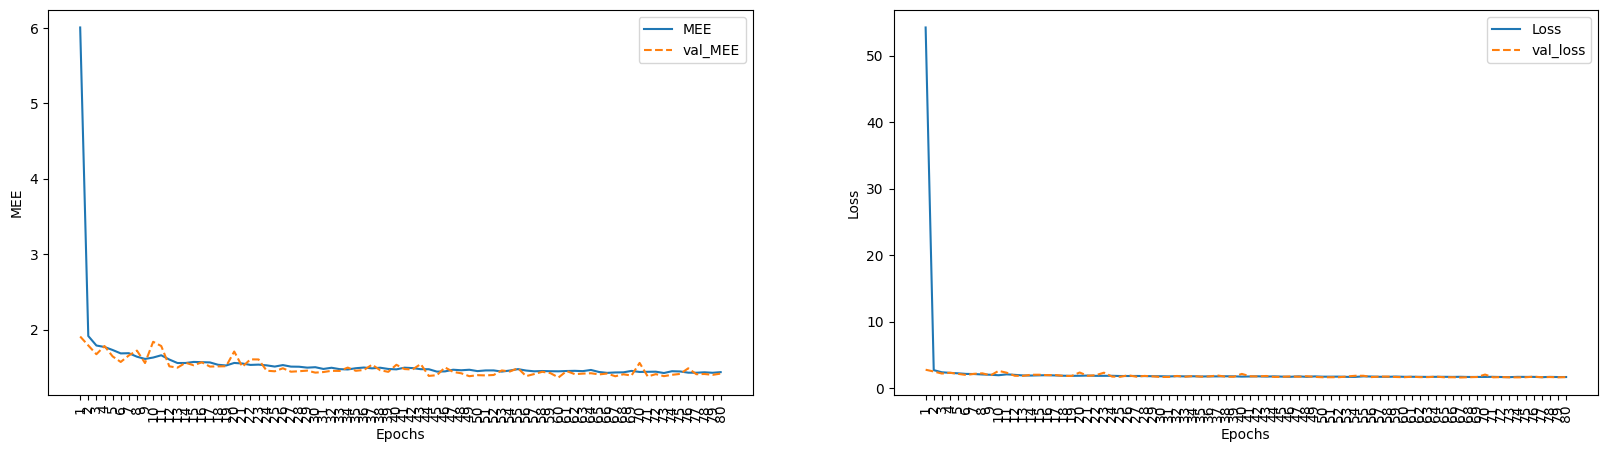

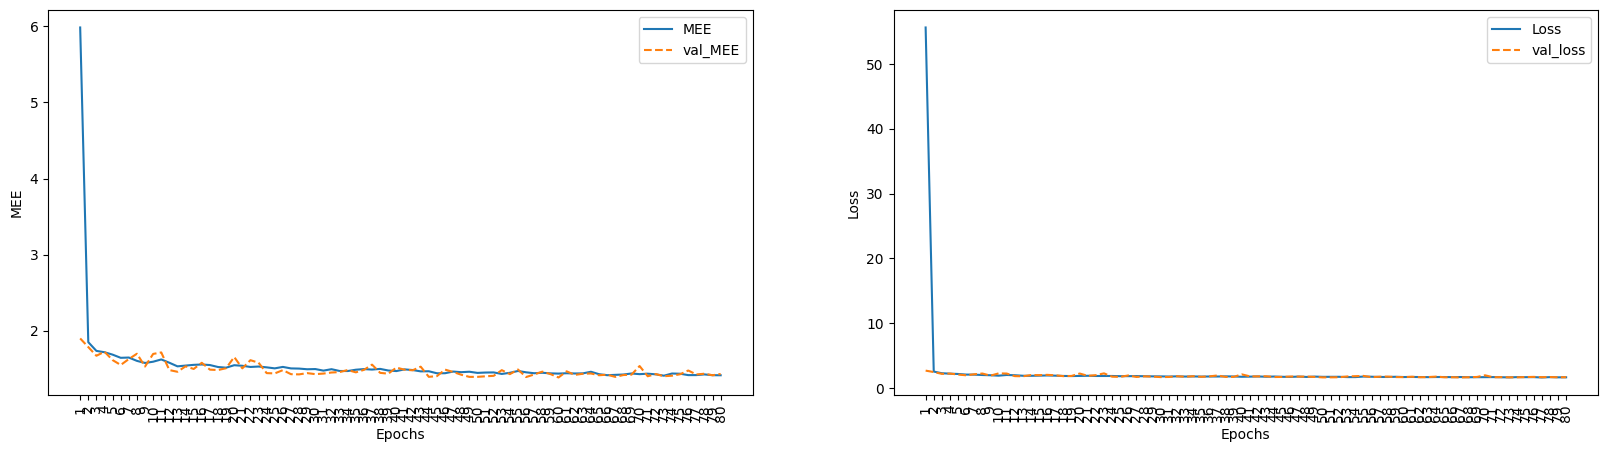

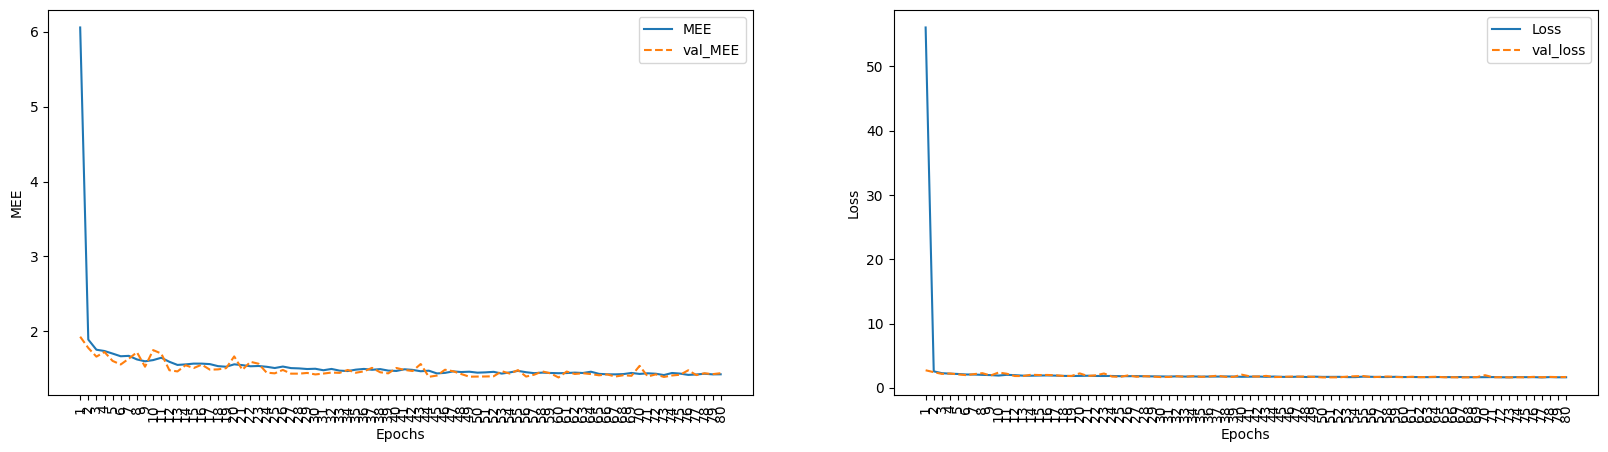

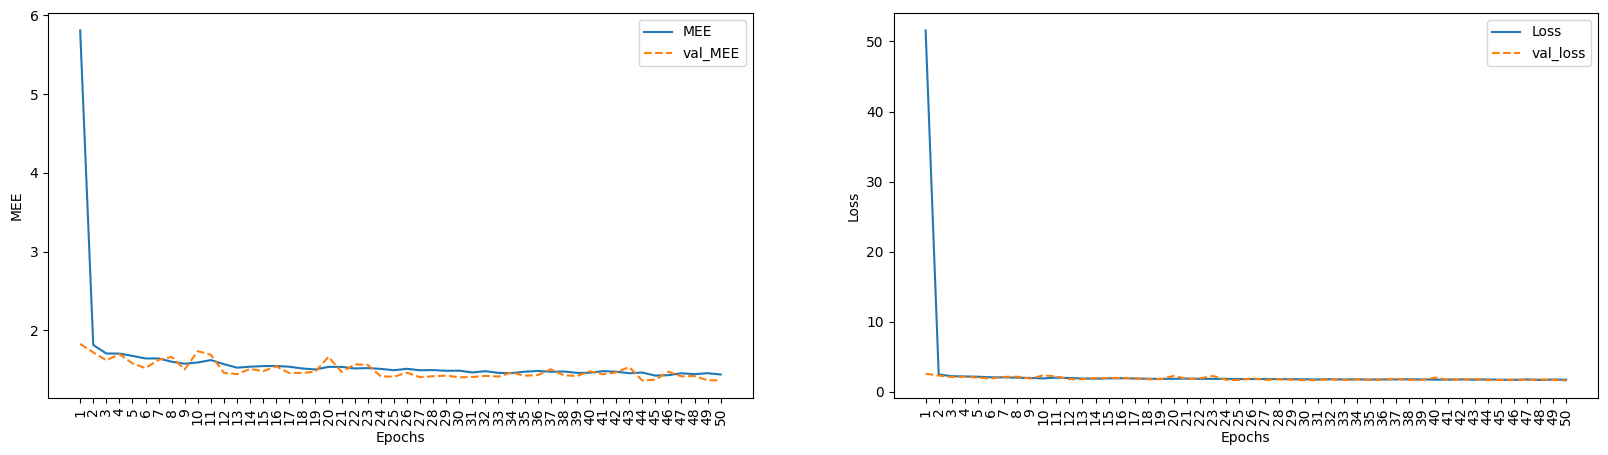

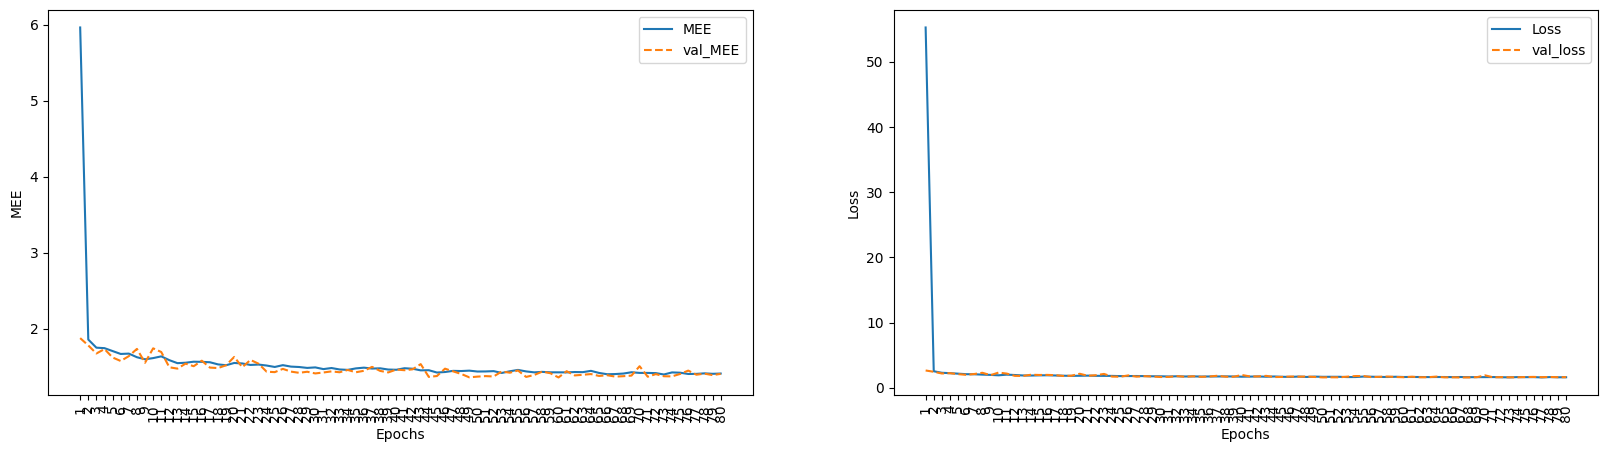

In [40]:
for i in range(5):

    b_ep = len(models_train_mee[i])-20

    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    #MEE plot
    axs[0].plot(models_train_mee[i][0:b_ep], label='MEE') 
    axs[0].plot(models_val_mee[i][0:b_ep], label='val_MEE', linestyle='dashed')       
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('MEE')
    #plt.ylim([0,5])
    axs[0].set_xticks(np.arange(len(models_train_mee[i][0:b_ep])), 
                        np.arange(1, len(models_train_mee[i][0:b_ep])+1), 
                        rotation=90)
    axs[0].legend(loc = 'upper right')

    #Loss plot
    axs[1].plot(models_train_mse[i][0:b_ep], label='Loss') 
    axs[1].plot(models_val_mse[i][0:b_ep], label='val_loss', linestyle='dashed')       
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    #plt.ylim([0,5])
    axs[1].set_xticks(np.arange(len(models_train_mse[i][0:b_ep])), 
            np.arange(1, len(models_train_mse[i][0:b_ep])+1), 
            rotation=90)
    axs[1].legend(loc = 'upper right')

    plt.show()

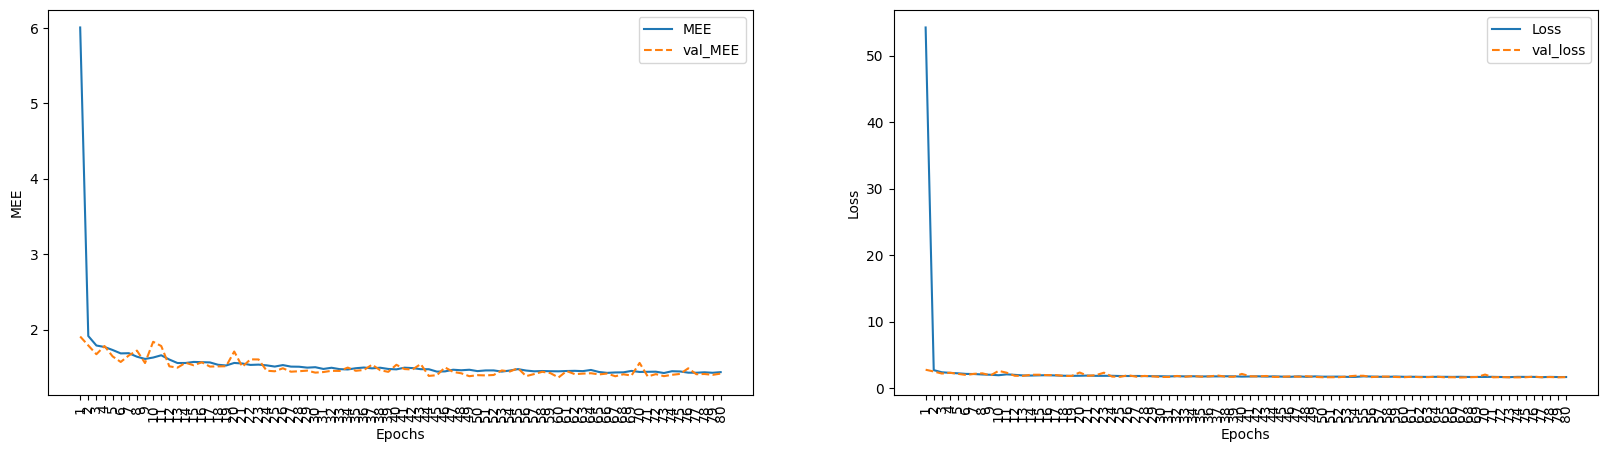

In [41]:
b_ep = len(models_train_mee[final_idx])-20

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
#MEE plot
axs[0].plot(models_train_mee[final_idx][0:b_ep], label='MEE') 
axs[0].plot(models_val_mee[final_idx][0:b_ep], label='val_MEE', linestyle='dashed')       
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MEE')
#plt.ylim([0,5])
axs[0].set_xticks(np.arange(len(models_train_mee[final_idx][0:b_ep])), 
                np.arange(1, len(models_train_mee[final_idx][0:b_ep])+1), 
                rotation=90)
axs[0].legend(loc = 'upper right')

#Loss plot
axs[1].plot(models_train_mse[final_idx][0:b_ep], label='Loss') 
axs[1].plot(models_val_mse[final_idx][0:b_ep], label='val_loss', linestyle='dashed')       
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
#plt.ylim([0,5])
axs[1].set_xticks(np.arange(len(models_train_mse[final_idx][0:b_ep])), 
        np.arange(1, len(models_train_mse[final_idx][0:b_ep])+1), 
        rotation=90)
axs[1].legend(loc = 'upper right')

plt.show()

Restoring model weights from the end of the best epoch: 25.
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 29.
Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 15.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 47.
Epoch 67: early stopping
Restoring model weights from the end of the best epoch: 31.
Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 38.
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 30.
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 39.
Epoch 59: early stopping
Restoring model weights from the end of the best epoch: 61.
Epoch 81: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 45.
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 73.
Epoch 

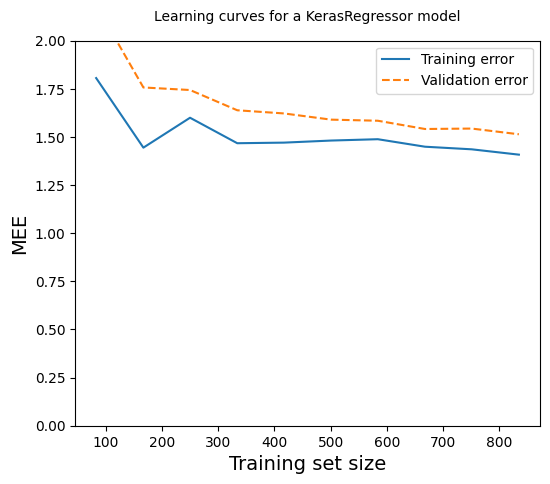

In [42]:
### Plotting the learning curves ###
plt.figure(figsize = (6,5))

learning_curves(final_models[final_idx], x_train, y_train, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 5)

In [43]:
final_models[final_idx].model_.save("cup_models/keras_median.h5")

In [44]:
# --------------------------------------------------------------------------------------------

### Final model

In [45]:
keras = load_model('cup_models/keras.h5', custom_objects={"MEE": MEE})

In [46]:
keras

In [47]:
train_pred_keras = keras.predict(x_train)

33/33 [==============================] - 0s 884us/step


In [48]:
print('MEE train set ', MEE(y_train, train_pred_keras))

MEE train set  tf.Tensor(1.3696550300577737, shape=(), dtype=float64)


In [49]:
test_pred_keras = keras.predict(x_test)

14/14 [==============================] - 0s 739us/step


In [50]:
print('MEE test set ', MEE(y_test, test_pred_keras))

MEE test set  tf.Tensor(1.4879572735094844, shape=(), dtype=float64)


[Text(0.5, 0, 'target_x'), Text(0, 0.5, 'target_y'), Text(0.5, 1.0, 'Targets')]

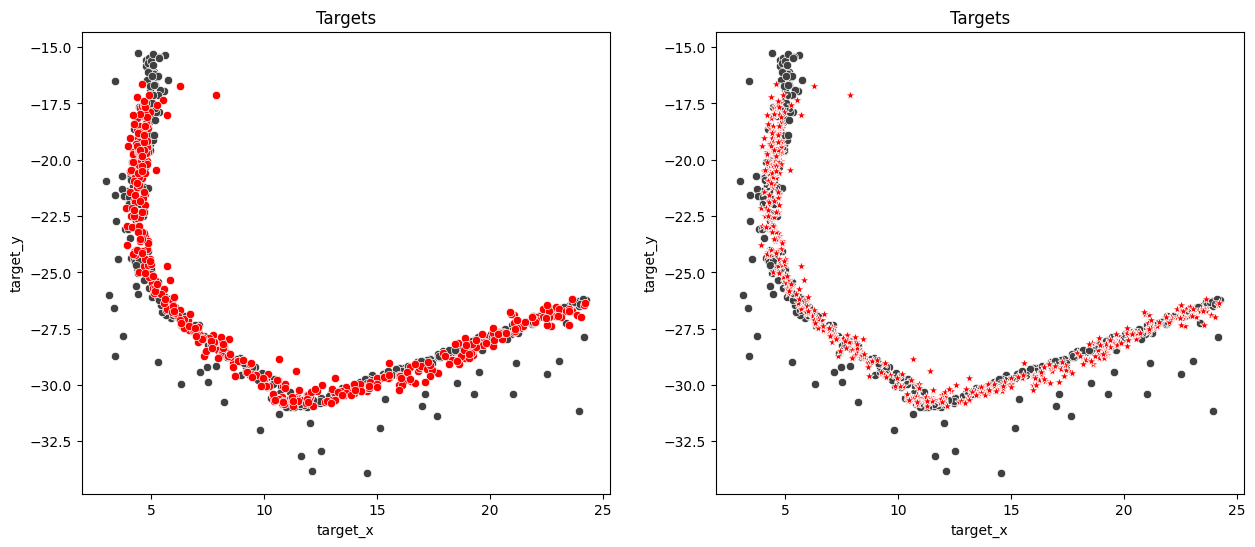

In [51]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.25',ax=ax[0])
sns.scatterplot(x=test_pred_keras[:,0],y=test_pred_keras[:,1],color='r',ax=ax[0])
ax[0].set(xlabel='target_x',ylabel='target_y',title='Targets')

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.25',ax=ax[1])
sns.scatterplot(x=test_pred_keras[:,0],y=test_pred_keras[:,1],color='r',ax=ax[1], marker='*', s=50)
ax[1].set(xlabel='target_x',ylabel='target_y',title='Targets')

[Text(0.5, 0, 'target_x'), Text(0, 0.5, 'target_y'), Text(0.5, 1.0, 'Targets')]

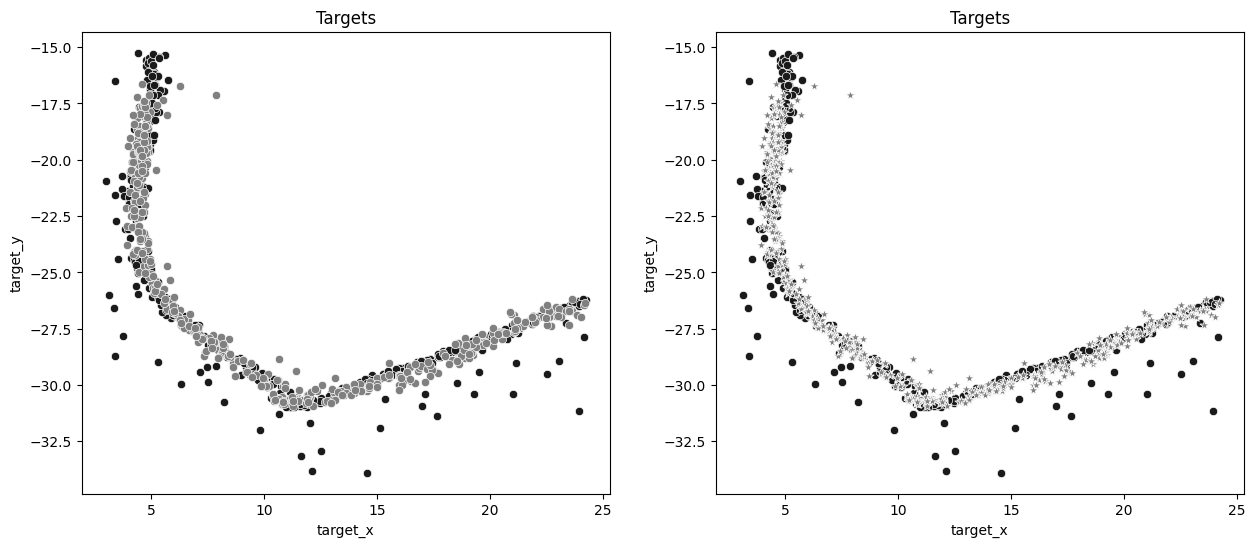

In [52]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.1',ax=ax[0])
sns.scatterplot(x=test_pred_keras[:,0],y=test_pred_keras[:,1],color='.5',ax=ax[0])
ax[0].set(xlabel='target_x',ylabel='target_y',title='Targets')

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.1',ax=ax[1])
sns.scatterplot(x=test_pred_keras[:,0],y=test_pred_keras[:,1],color='.5',ax=ax[1], marker='*', s=50)
ax[1].set(xlabel='target_x',ylabel='target_y',title='Targets')

In [53]:
results.append(('MLP_keras train', MEE(y_train, train_pred_keras)))
results.append(('MLP_keras validation', mlp_cv.best_score_))

# Summary

In [54]:
for i in range(len(results)):
  print(results[i])

('MLP_keras train', <tf.Tensor: shape=(), dtype=float64, numpy=1.3696550300577737>)
('MLP_keras validation', -1.5033600570628964)


In [55]:
keras_median = load_model('cup_models/keras_median.h5', custom_objects={"MEE": MEE})
keras_median

In [56]:
train_pred_keras_median = keras_median.predict(x_train)
print('MEE train set ', MEE(y_train, train_pred_keras_median))

print('MEE val set', models_val_mee[final_idx][-21])

33/33 [==============================] - 0s 2ms/step
MEE train set  tf.Tensor(1.3976219659265348, shape=(), dtype=float64)
MEE val set 1.4151191711425781


In [57]:
test_pred_keras_median = keras_median.predict(x_test)
print('MEE test set ', MEE(y_test, test_pred_keras_median))

14/14 [==============================] - 0s 811us/step
MEE test set  tf.Tensor(1.5154584516742742, shape=(), dtype=float64)
